<a href="https://colab.research.google.com/github/Lama-Aldhafeeri/TaSch/blob/main/ACO_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetch Dataset

In [1]:
import os
import zipfile
import requests

# Define the GitHub raw file URL
zip_url = "https://github.com/Lama-Aldhafeeri/TaSch/raw/main/task_machine_datasets_200.zip"

# Download the zip file
zip_path = "task_machine_datasets_200.zip"
response = requests.get(zip_url)
with open(zip_path, "wb") as file:
    file.write(response.content)

# Extract the zip file
dataset_path = "dataset"
os.makedirs(dataset_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(dataset_path)

# Verify extraction
dataset_files = sorted(os.listdir(dataset_path))
print(f"Extracted {len(dataset_files)} dataset files!")
print(f"Example file: {dataset_files[:5]}")

Extracted 200 dataset files!
Example file: ['instance_10_100_1.txt', 'instance_10_100_10.txt', 'instance_10_100_11.txt', 'instance_10_100_12.txt', 'instance_10_100_13.txt']


Load Dataset Files

In [2]:
import os
import numpy as np
import pandas as pd

def read_data(file_path):
    """Reads benchmark data from a given file."""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Parse tasks
    tasks = list(map(int, lines[0].strip().split()))

    # Parse virtual machines
    vms = list(map(int, lines[1].strip().split()))

    # Parse execution times
    times = {}
    for entry in lines[2:]:
        task, vm, time = map(int, entry.strip().strip("()").split(","))
        times[(task, vm)] = time
    return tasks, vms, times


# Verify dataset loading
print(f"Loaded {len(dataset_files)} dataset files!")
print(f"Example file: {dataset_files[0]}")

Loaded 200 dataset files!
Example file: instance_10_100_1.txt


Setup compute imbalance factor

In [3]:
def compute_degree_of_imbalance(vm_loads):
    """Compute Degree of Imbalance (DI) as per Eq. (8)."""
    T_max = np.max(vm_loads)  # Maximum execution time among VMs
    T_min = np.min(vm_loads)  # Minimum execution time among VMs
    T_avg = np.mean(vm_loads)  # Average execution time among VMs

    if T_avg == 0:
        return 0  # Avoid division by zero

    DI = (T_max + T_min) / T_avg
    return DI

Define the ACO

In [4]:
import numpy as np

class AntColonyOptimization:
    def __init__(self, num_ants, num_iterations, alpha, beta, rho, Q):
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha
        self.beta = beta
        self.rho = rho  # Evaporation rate
        self.Q = Q  # Pheromone deposit factor

    def run(self, distance_matrix):
        """Run the ACO algorithm for a given distance matrix (task-VM execution times)."""
        num_tasks, num_vms = distance_matrix.shape

        # Compute heuristic values (η_ij = 1 / d_ij), avoiding division by zero
        heuristic_matrix = np.where(distance_matrix > 0, 1 / distance_matrix, 1e-10)

        # Initialize pheromone matrix (τ_ij = 1)
        pheromone_matrix = np.ones((num_tasks, num_vms))

        # Track best solution
        best_solution = None
        best_makespan = float('inf')
        best_vm_loads = None  # Store best VM loads

        # ACO Algorithm
        for iteration in range(self.num_iterations):
            all_solutions = []
            all_makespans = []
            all_vm_loads = []

            for ant in range(self.num_ants):
                solution = []
                vm_loads = np.zeros(num_vms)  # Initialize VM loads

                for task in range(num_tasks):
                    # Compute probabilities for each VM
                    probabilities = (pheromone_matrix[task] ** self.alpha) * (heuristic_matrix[task] ** self.beta)

                    # Add a small value to avoid zero division
                    prob_sum = probabilities.sum()
                    if prob_sum == 0:
                        probabilities = np.ones(num_vms) / num_vms  # Reset to equal probability
                    else:
                        probabilities /= prob_sum

                    # Select VM based on probability
                    vm_choice = np.random.choice(num_vms, p=probabilities)
                    solution.append((task, vm_choice))
                    vm_loads[vm_choice] += distance_matrix[task, vm_choice]  # Update VM load

                    # Apply Local Pheromone Update using the given formula
                    delta_tau = self.Q / (distance_matrix[task, vm_choice] + 1e-10)  # Small value to avoid div by zero
                    pheromone_matrix[task, vm_choice] = (1 - self.rho) * pheromone_matrix[task, vm_choice] + delta_tau

                # Compute makespan
                makespan = max(vm_loads)
                all_solutions.append(solution)
                all_makespans.append(makespan)
                all_vm_loads.append(vm_loads.copy())

            # Select best solution from this iteration
            min_index = np.argmin(all_makespans)
            if all_makespans[min_index] < best_makespan:
                best_makespan = all_makespans[min_index]
                best_solution = all_solutions[min_index]
                best_vm_loads = all_vm_loads[min_index]

            # Global Pheromone Update
            pheromone_matrix *= (1 - self.rho)  # Evaporation
            for task, vm in best_solution:
                pheromone_matrix[task, vm] += self.Q / best_makespan

        return best_solution, best_makespan, best_vm_loads, all_makespans

Apply ACO on a Small Example

In [5]:
# Apply ACO on a Small Example

# Define a small 5-task, 3-VM problem
small_distance_matrix = np.array([
    [7, 8, 5],
    [6, 7, 9],
    [8, 5, 6],
    [9, 6, 7],
    [5, 9, 8]
])

# Initialize and Run ACO
aco = AntColonyOptimization(num_ants=5, num_iterations=50, alpha=1, beta=2, rho=0.1, Q=100)
best_solution, best_makespan, _ , _ = aco.run(small_distance_matrix)

# Print results for the small example
print("\n Small Example:")
print(f"Best Solution: {best_solution}")
print(f"Best Makespan: {best_makespan}")


 Small Example:
Best Solution: [(0, 0), (1, 2), (2, 1), (3, 1), (4, 0)]
Best Makespan: 12.0


Test ACO On Generated Dataset

In [6]:
# Initialize ACO
aco = AntColonyOptimization(num_ants=10, num_iterations=100, alpha=0.3, beta=1, rho=0.5, Q=100)

# Store Results for Plotting
results = {
    "dataset": [],
    "num_tasks": [],
    "best_makespan": [],
    "worst_makespan": [],
    "avg_makespan": [],
    "degree_of_imbalance": []
}

# Dataset path (change this to your directory)
dataset_path = "dataset"
dataset_files = os.listdir(dataset_path)

# Apply ACO to All Datasets and Collect Data
for dataset_file in dataset_files:
    file_path = os.path.join(dataset_path, dataset_file)
    tasks, vms, times = read_data(file_path)

    # Extract task and VM counts
    num_tasks = len(tasks)
    num_vms = len(vms)


    # Create distance matrix
    distance_matrix = np.zeros((num_tasks, num_vms))
    for (task, vm), time in times.items():
        distance_matrix[task - 1, vm - 1] = time  # Adjust index for 0-based array
    # print(f"\nDistance Matrix for {dataset_file}:\n", distance_matrix)

    # Run ACO
    aco.num_tasks = num_tasks
    aco.num_vms = num_vms
    aco.distance_matrix = distance_matrix

    best_solution, best_makespan, best_vm_loads, all_makespans = aco.run(distance_matrix)

    # Compute Best, Worst, and Average Makespan
    worst_makespan = max(all_makespans)  # Worst makespan (highest)
    avg_makespan = np.mean(all_makespans)  # # Average best makespan per iteration

    # Compute Load Imbalance: Balance Factor = Max Load / Average Load
    avg_load = np.mean(best_vm_loads)
    max_load = np.max(best_vm_loads)

    # Compute Corrected Degree of Imbalance (DI)
    degree_of_imbalance = compute_degree_of_imbalance(best_vm_loads)
    print(f"dataset: {dataset_file}")
    print(f"Best Makespan: {best_makespan}")
    print("\nBest VM Loads for", dataset_file, ":", best_vm_loads)
    print(f"Computed Best Makespan (max VM load): {max(best_vm_loads)}")
    print(f"Total Task Execution Time for {dataset_file}: {np.sum(distance_matrix)}")

    # Store Results
    results["dataset"].append(dataset_file)
    results["num_tasks"].append(num_tasks)
    results["best_makespan"].append(best_makespan)
    results["worst_makespan"].append(worst_makespan)
    results["avg_makespan"].append(avg_makespan)
    results["degree_of_imbalance"].append(degree_of_imbalance)

# Convert results to DataFrame
df_results = pd.DataFrame(results)
print(df_results)

dataset: instance_10_100_16.txt
Best Makespan: 75.0

Best VM Loads for instance_10_100_16.txt : [75. 53. 70. 75. 57. 73. 52. 74. 75. 48.]
Computed Best Makespan (max VM load): 75.0
Total Task Execution Time for instance_10_100_16.txt: 7576.0
dataset: instance_10_80_17.txt
Best Makespan: 59.0

Best VM Loads for instance_10_80_17.txt : [50. 31. 58. 59. 56. 59. 58. 48. 48. 37.]
Computed Best Makespan (max VM load): 59.0
Total Task Execution Time for instance_10_80_17.txt: 5987.0
dataset: instance_10_20_10.txt
Best Makespan: 17.0

Best VM Loads for instance_10_20_10.txt : [14. 14. 17. 16. 12. 14. 14.  8. 14. 13.]
Computed Best Makespan (max VM load): 17.0
Total Task Execution Time for instance_10_20_10.txt: 1503.0
dataset: instance_10_10_12.txt
Best Makespan: 10.0

Best VM Loads for instance_10_10_12.txt : [ 6.  8.  7. 10.  9.  0.  5.  8.  5.  7.]
Computed Best Makespan (max VM load): 10.0
Total Task Execution Time for instance_10_10_12.txt: 783.0
dataset: instance_10_70_9.txt
Best Makespa

In [7]:
# Find the Best Result from the Results List

# Find the dataset with the minimum (best) makespan
best_index = df_results["best_makespan"].idxmin()
best_result = df_results.loc[best_index]

# Print the best result
print("Best Result Found:")
print(best_result)

Best Result Found:
dataset                instance_10_10_4.txt
num_tasks                                10
best_makespan                           7.0
worst_makespan                         28.0
avg_makespan                           17.9
degree_of_imbalance                1.967213
Name: 136, dtype: object


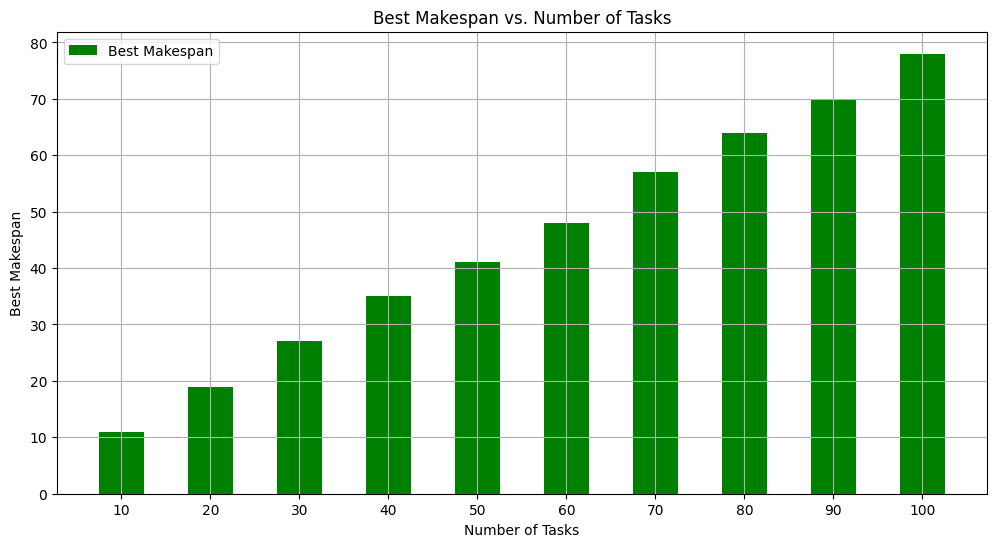

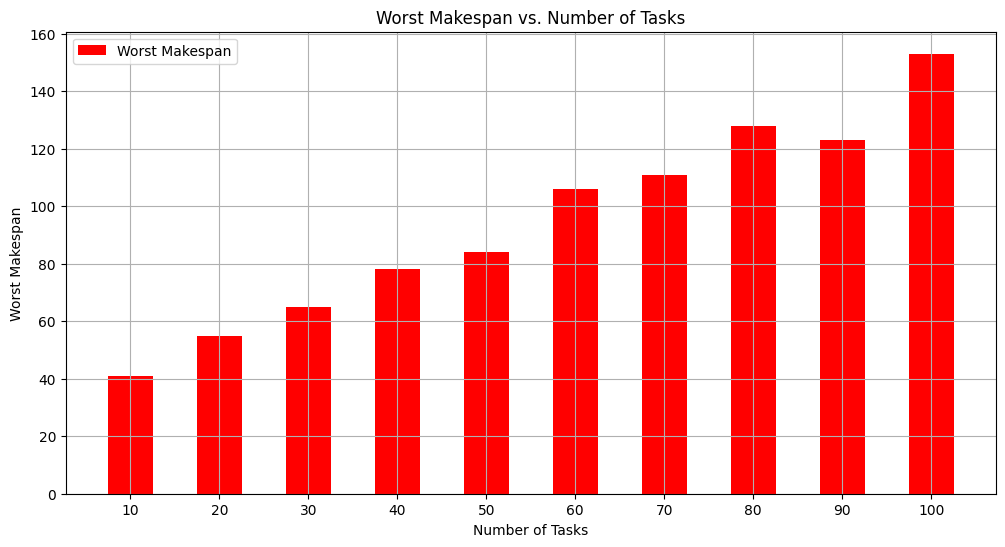

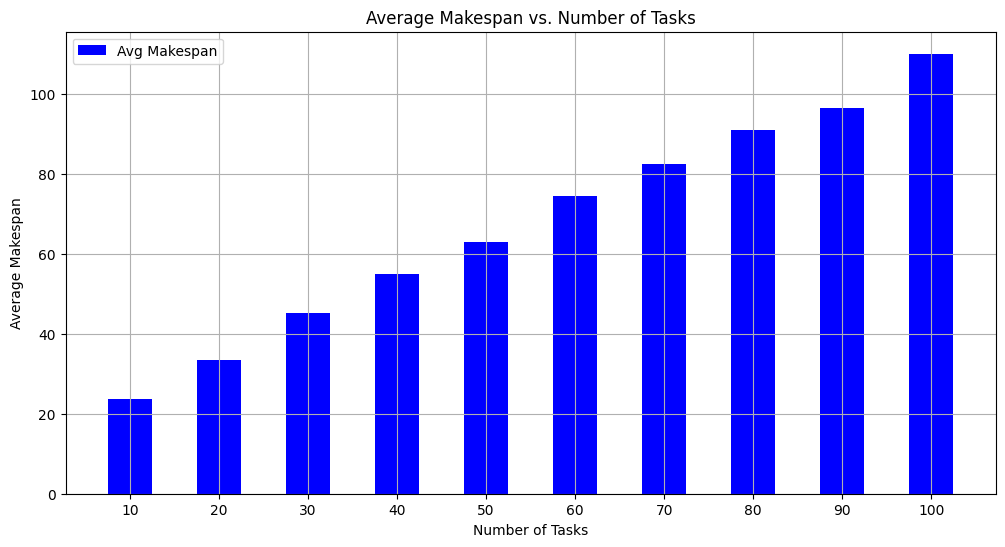

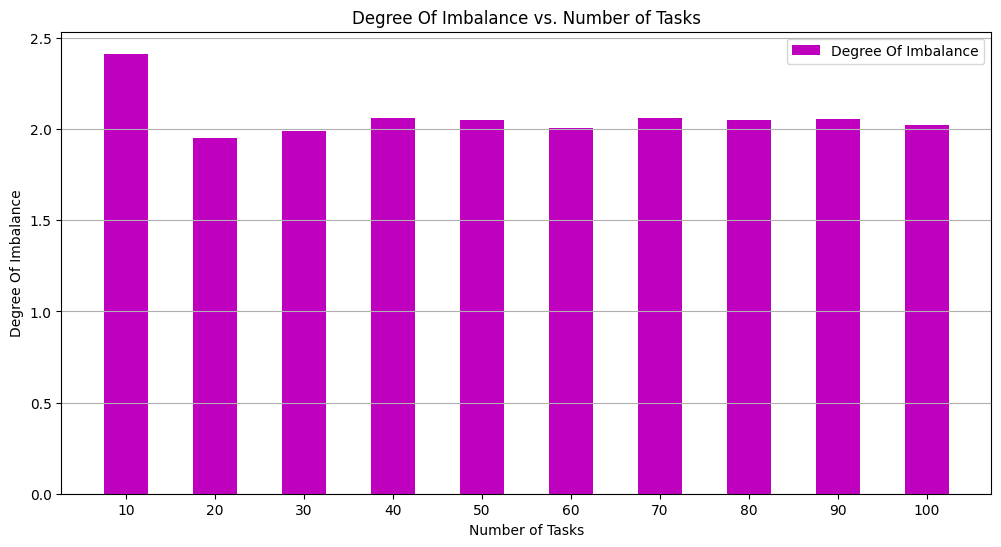

,dataset,num_tasks,best_makespan,worst_makespan,avg_makespan,degree_of_imbalance
0,instance_10_100_16.txt,100,75.0,130.0,102.0,1.886503
1,instance_10_80_17.txt,80,59.0,101.0,86.4,1.785714
2,instance_10_20_10.txt,20,17.0,43.0,33.5,1.838235
3,instance_10_10_12.txt,10,10.0,24.0,20.0,1.538462
4,instance_10_70_9.txt,70,55.0,96.0,76.7,1.758242
...,...,...,...,...,...,...
195,instance_10_80_10.txt,80,63.0,94.0,80.3,1.705882
196,instance_10_70_13.txt,70,54.0,89.0,74.7,1.870824
197,instance_10_10_13.txt,10,11.0,40.0,20.3,1.641791
198,instance_10_10_10.txt,10,9.0,33.0,16.7,2.295082


In [9]:
import matplotlib.pyplot as plt

#  Plot Best Makespan vs. Number of Tasks
plt.figure(figsize=(12, 6))
plt.bar(df_results["num_tasks"], df_results["best_makespan"], color='g', label="Best Makespan", width=5)
plt.xlabel("Number of Tasks")
plt.ylabel("Best Makespan")
plt.title("Best Makespan vs. Number of Tasks")
plt.xticks(ticks=range(10, 110, 10))  # Ensure x-axis shows 10, 20, ..., 100
plt.legend()
plt.grid()
plt.show()

#  Plot Worst Makespan vs. Number of Tasks
plt.figure(figsize=(12, 6))
plt.bar(df_results["num_tasks"], df_results["worst_makespan"], color='r', label="Worst Makespan", width=5)
plt.xlabel("Number of Tasks")
plt.ylabel("Worst Makespan")
plt.title("Worst Makespan vs. Number of Tasks")
plt.xticks(ticks=range(10, 110, 10))
plt.legend()
plt.grid()
plt.show()

#  Plot Average Makespan vs. Number of Tasks
plt.figure(figsize=(12, 6))
plt.bar(df_results["num_tasks"], df_results["avg_makespan"],color='b', label="Avg Makespan", width=5)
plt.xlabel("Number of Tasks")
plt.ylabel("Average Makespan")
plt.title("Average Makespan vs. Number of Tasks")
plt.xticks(ticks=range(10, 110, 10))
plt.legend()
plt.grid()
plt.show()

#  Plot Degree Of Imbalance vs. Number of Tasks
plt.figure(figsize=(12, 6))
plt.bar(df_results["num_tasks"], df_results["degree_of_imbalance"], color='m', label="Degree Of Imbalance", width=5)
plt.xlabel("Number of Tasks")
plt.ylabel("Degree Of Imbalance")
plt.title("Degree Of Imbalance vs. Number of Tasks")
plt.xticks(ticks=range(10, 110, 10))  # Ensure x-axis shows 10, 20, ..., 100
plt.legend()
plt.grid(axis='y')
plt.show()

#  Display updated results table
display(df_results)